In [1]:
import itertools
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from statsmodels.tsa.arima.model import ARIMA
import sys


# Add the path to your folder to the Python module search path
sys.path.append('../')
# Now you can import the module from your file
from agros.agros_analysis import Agros

module = Agros()

warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv('../downloads/Data.csv')

def arima_grid_search(data: list, seasonal: bool = False) -> Tuple:
    """
    Grid search to find the best ARIMA model parameters for the given data.

    Args:
        data (pandas.Series): Time series data to be fitted with ARIMA models.
        seasonal (bool): Whether to include seasonal components in the ARIMA models. Default is False.

    Returns:
        tuple: A tuple containing the best ARIMA model parameters and the corresponding AIC value.

    Raises:
        None
    """
    p_values = [0, 1, 2]
    d_values = range(0, 2)
    q_values = range(0, 2)
    
    if seasonal:
        P_values = range(0, 2)
        D_values = range(0, 1)
        Q_values = range(0, 2)
        m_values = [12]
        grid = itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m_values)
    else:
        grid = itertools.product(p_values, d_values, q_values)
        
    best_aic = float("inf")
    best_params = None
    
    for params in grid:
        try:
            model = ARIMA(data, order=params)
            results = model.fit()
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = params
                
        except:
            continue
        
    return best_params, best_aic


def tfp_predictor(*countries: str, seasonal: bool = True) -> None:
    """
    Generate a plot of predicted TFP values for the specified countries.

    Args:
        *countries: List of country names to include in the plot. Max 3
        seasonal (bool, optional): Whether or not to include seasonal adjustments in the ARIMA model.
            Defaults to True.

    Raises:
        ValueError: If none of the specified countries are available in the data.

    Returns:
        None

    """
    # Use agros method 3 for country list
    available_countries = module.countries_list()

    # Check if countries are in available_countries
    valid_countries = [country for country in countries if country in available_countries]

    # Check if there are any valid countries
    if not valid_countries:
        raise ValueError(f"None of the specified countries are available in the data. \nAvailable countries are:\n{', '.join(available_countries)}")

    # Limit to max 3 countries
    if len(valid_countries) > 3:
        print(f"Warning: Only the first 3 valid countries ({', '.join(valid_countries[:3])}) will be considered. The rest will be ignored.")

    # Define line styles for actual and predicted data
    line_styles = ['-', ':']

    # Define the colors
    num_colors = min(len(valid_countries), 3)
    color_cycle = ['blue', 'orange', 'green'][:num_colors]
    # Create a dictionary to map countries to colors
    country_colors = dict(zip(valid_countries, color_cycle))
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_cycle)

    for i, country in enumerate(valid_countries[:3]):
        # Data for the specified countries
        country_data = data[data['Entity'] == country.title()]
        # Extract tfp data
        tfp_data = country_data[['Year', 'tfp']].dropna()
        # Convert Year column to datetime
        tfp_data['Year'] = pd.to_datetime(tfp_data['Year'], format='%Y')
        # Set Year column as index
        tfp_data.set_index('Year', inplace=True)
        # Set frequency
        tfp_data.index.freq = 'YS'
        # Perform a grid search for the optimal ARIMA parameters
        best_params, best_aic = arima_grid_search(tfp_data)
        # Print the results (to be removed once the code runs)
        print("Best (p, d, q) parameters: ", best_params)
        print("AIC score of the best model: ", best_aic)
        # Plot tfp data until 2019 with solid line
        plt.plot(tfp_data.loc[:'2019'].index, tfp_data.loc[:'2019']['tfp'], linestyle=line_styles[0], label=country.title(),color=country_colors[country])
        # Pandas DatetimeIndex object with yearly frequency, years from 2020 to 2050 (inclusive)
        future_years = pd.date_range(start='2020', end='2050', freq='Y')
        # Fit an ARIMA model to the tfp data
        model = ARIMA(tfp_data, order=best_params)
        model_fit = model.fit()
        predictions = model_fit.predict(start='2020', end='2050')
        # Remove last prediction to align with x axis
        predictions = predictions[:-1]
        # Plot the predicted values with dashed lines
        plt.plot(future_years, predictions, linestyle=line_styles[1], color=country_colors[country])
        # Add labels and legend to the plot
    plt.xlabel('Year')
    plt.ylabel('TFP')
    plt.title('TFP Prediction Country Comparison')
    plt.legend()
    plt.annotate(
        text="Source: Our World in Data, Feb 1, 2022",
        xy=(1, 1),
        xycoords="figure points",
        )
    plt.show()


Best (p, d, q) parameters:  (0, 1, 1)
AIC score of the best model:  310.5218869327233
Best (p, d, q) parameters:  (2, 1, 1)
AIC score of the best model:  350.3641143638179
Best (p, d, q) parameters:  (1, 1, 1)
AIC score of the best model:  263.7720086302411


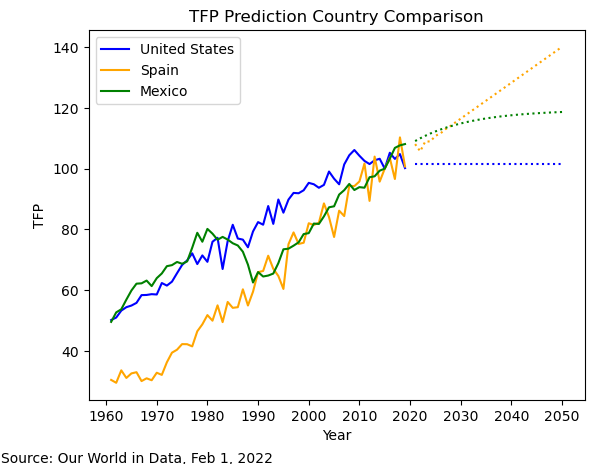

In [2]:
tfp_predictor('United States', 'Spain', 'Mexico', "Sweden")